# 上市公司得分分析（年度与月度 | 行业视角）

本笔记对 `year_code.csv` 与 `month_code.csv` 进行时间趋势与行业对比分析；行业信息来自 `STK_LISTEDCOINFOANL.csv`（变量说明见 `STK_LISTEDCOINFOANL[DES][csv].txt`）。

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)
sns.set(style='whitegrid', context='notebook')

DATA_YEAR = Path('year_code.csv')
DATA_MONTH = Path('month_code.csv')
DATA_INFO = Path('STK_LISTEDCOINFOANL.csv')
DATA_DESC = Path('STK_LISTEDCOINFOANL[DES][csv].txt')

In [2]:
def read_csv_robust(path: Path, parse_dates=None):
    encodings = ['utf-8', 'gbk', 'gb18030']
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, parse_dates=parse_dates)
        except Exception as e:
            last_err = e
    raise last_err

def drop_unnamed(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[:, ~df.columns.str.startswith('Unnamed')]

def ensure_code_str(s: pd.Series) -> pd.Series:
    return s.astype(str).str.replace(r'\.0$', '', regex=True).str.zfill(6)

In [4]:
# 读取年度与月度得分
year_df = drop_unnamed(read_csv_robust(DATA_YEAR))
year_df2 = pd.read_csv('year_code(2324).csv')
year_df2 = year_df2[['code','year','score']]
year_df = pd.concat([year_df, year_df2], ignore_index=True)
month_df = drop_unnamed(read_csv_robust(DATA_MONTH))

# 读取行业信息；EndDate 解析为日期，提取年份
info_df = read_csv_robust(DATA_INFO, parse_dates=['EndDate'])
info_df['year'] = info_df['EndDate'].dt.year

# 统一代码格式
year_df['code'] = ensure_code_str(year_df['code'])
month_df['code'] = ensure_code_str(month_df['code'])
info_df['Symbol'] = ensure_code_str(info_df['Symbol'])

# 类型清洗
year_df['year'] = pd.to_numeric(year_df['year'], errors='coerce').astype('Int64')
month_df['year_month'] = pd.to_datetime(month_df['year_month'], format='%Y-%m', errors='coerce')
month_df['year'] = month_df['year_month'].dt.year

# 行业口径：同一代码同一年取最新一条 EndDate 记录
info_year = (
    info_df.sort_values(['Symbol', 'year', 'EndDate'])
            .drop_duplicates(['Symbol', 'year'], keep='last')
            [['Symbol', 'year', 'IndustryNameC', 'IndustryCodeD']]
)

# 合并行业到年度与月度数据
year_enriched = year_df.merge(info_year, left_on=['code', 'year'], right_on=['Symbol', 'year'], how='left')
month_enriched = month_df.merge(info_year, left_on=['code', 'year'], right_on=['Symbol', 'year'], how='left')

# 便于显示
year_enriched.rename(columns={'IndustryNameC': 'industry'}, inplace=True)
month_enriched.rename(columns={'IndustryNameC': 'industry'}, inplace=True)

print('year_df:', year_df.shape, year_df.head(3), sep='\n')
print('month_df:', month_df.shape, month_df.head(3), sep='\n')
print('info_year:', info_year.shape, info_year.head(3), sep='\n')
print('year_enriched:', year_enriched.shape, year_enriched.head(3), sep='\n')

year_df:
(74982, 3)
     code  year     score
0  000001  2015  0.533768
1  000001  2016  0.547963
2  000001  2017  0.551261
month_df:
(291480, 4)
     code year_month     score  year
0  000001 2015-01-01  0.576562  2015
1  000001 2015-03-01  0.548958  2015
2  000001 2015-04-01  0.516979  2015
info_year:
(31954, 4)
   Symbol  year IndustryNameC IndustryCodeD
0  000001  2015        货币金融服务           J66
1  000001  2016        货币金融服务           J66
2  000001  2017        货币金融服务           J66
year_enriched:
(74982, 6)
     code  year     score  Symbol industry IndustryCodeD
0  000001  2015  0.533768  000001   货币金融服务           J66
1  000001  2016  0.547963  000001   货币金融服务           J66
2  000001  2017  0.551261  000001   货币金融服务           J66


## 年度趋势（全市场）

以所有代码为样本，计算每年的平均得分（同时展示中位数与样本量）。

,year,mean,median,n
0,2015,0.483675,0.488934,8030
1,2016,0.478934,0.485675,8463
2,2017,0.474507,0.479891,8774
3,2018,0.471578,0.474667,8812
4,2019,0.468205,0.471133,8857
5,2020,0.464670,0.467777,8862
6,2021,0.465902,0.470000,8897
7,2022,0.467145,0.471861,6022
8,2023,0.465143,0.466575,4168
9,2024,0.459343,0.462445,4097


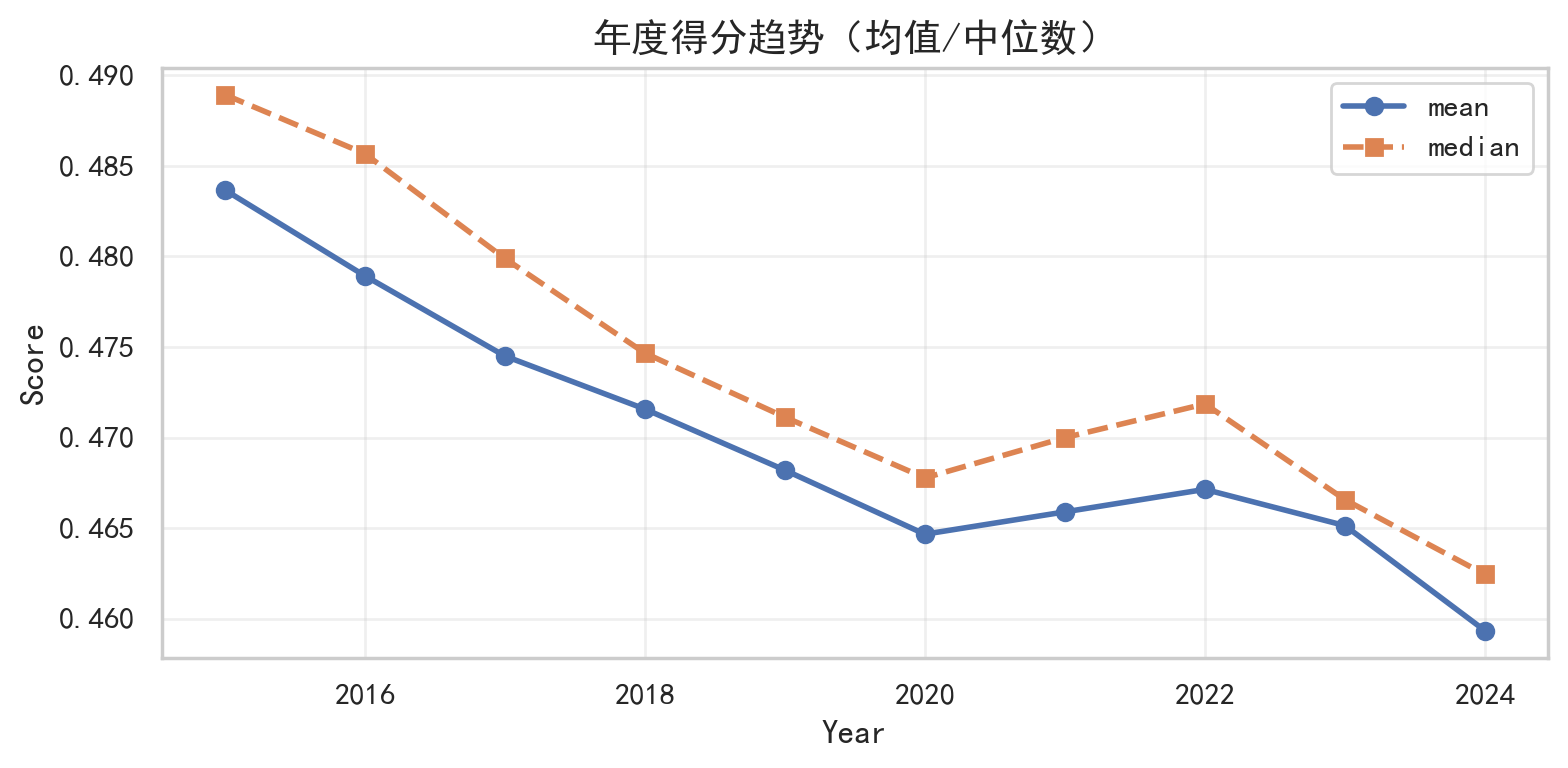

In [6]:
year_trend = (
    year_enriched.dropna(subset=['year'])
                .groupby('year')['score']
                .agg(mean='mean', median='median', n='size')
)
display(year_trend.reset_index())

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(figsize=(8, 4), dpi=200)
ax.plot(year_trend.index, year_trend['mean'], marker='o', label='mean', linewidth=2, markersize=6)
ax.plot(year_trend.index, year_trend['median'], marker='s', linestyle='--', label='median', linewidth=2, markersize=6)
ax.set_title('年度得分趋势（均值/中位数）', fontsize=14, fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 年度 × 行业 对比

按行业统计每年的平均得分，并展示最近年份的行业排名（Top 10）。

,year,industry,score
0,2015,专业技术服务业,0.486518
1,2015,专用设备制造业,0.468857
2,2015,互联网和相关服务,0.577882
3,2015,仓储业,0.492625
4,2015,仪器仪表制造业,0.502494


最近年份: 2024


,mean_score,n
industry,,
未知行业,0.459343,4097


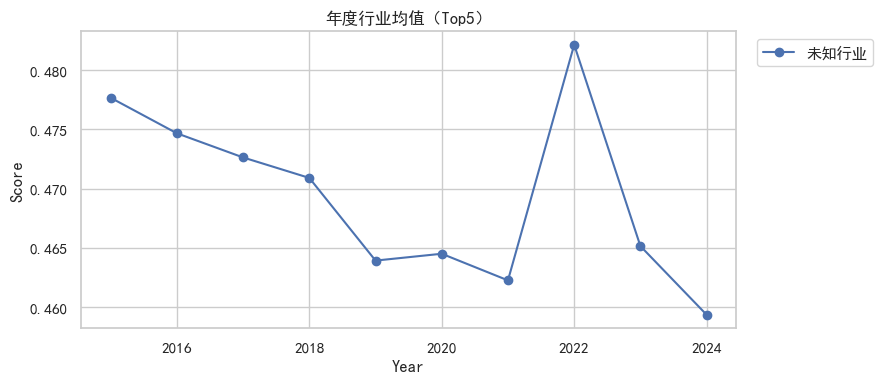

In [7]:
year_ind = (
    year_enriched.assign(industry=year_enriched['industry'].fillna('未知行业'))
                 .groupby(['year', 'industry'])['score']
                 .mean()
                 .reset_index()
)
display(year_ind.head())

latest_year = int(year_enriched['year'].dropna().max())
rank_latest = (
    year_enriched[year_enriched['year'] == latest_year]
        .assign(industry=lambda d: d['industry'].fillna('未知行业'))
        .groupby('industry')['score'].agg(mean_score='mean', n='size')
        .sort_values('mean_score', ascending=False)
        .head(10)
)
print(f'最近年份: {latest_year}')
display(rank_latest)

# 选择Top5行业绘制年度趋势
top5 = rank_latest.head(5).index.tolist()
plot_df = year_ind[year_ind['industry'].isin(top5)]
fig, ax = plt.subplots(figsize=(9, 4))
for ind, grp in plot_df.groupby('industry'):
    ax.plot(grp['year'], grp['score'], marker='o', label=ind)
ax.set_title('年度行业均值（Top5）')
ax.set_xlabel('Year')
ax.set_ylabel('Score')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 月度趋势（全市场）

将 `year_month` 解析为月份，按月计算全样本平均得分。

,year_month,score
0,2015-01-01,0.483387
1,2015-02-01,0.487038
2,2015-03-01,0.482884
3,2015-04-01,0.487840
4,2015-05-01,0.484483


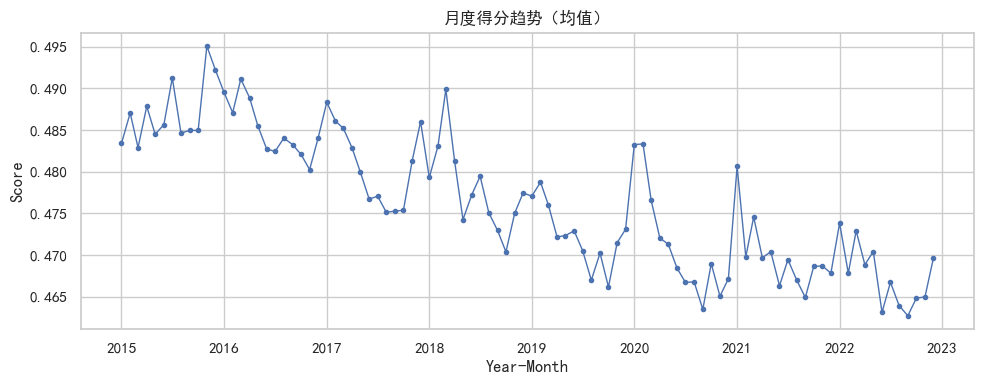

In [9]:
month_trend = (
    month_enriched.dropna(subset=['year_month'])
                 .groupby('year_month')['score']
                 .mean()
                 .reset_index()
)
display(month_trend.head())

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(month_trend['year_month'], month_trend['score'], marker='.', linewidth=1)
ax.set_title('月度得分趋势（均值）')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Score')
plt.tight_layout()
plt.show()

## 月度 × 行业 对比

选择最近年份Top5行业，观察其月度走势。

,year_month,industry,score
0,2015-01-01,保险业,0.477689
1,2015-01-01,农业,0.572500
2,2015-01-01,新闻和出版业,0.565624
3,2015-02-01,保险业,0.610294
4,2015-02-01,新闻和出版业,0.440476


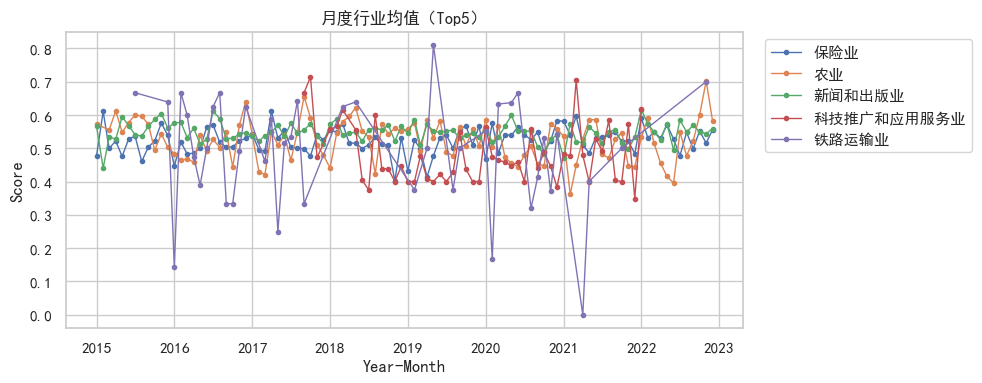

In [10]:
# 以最近年份的Top5行业为例
top5_inds = (
    year_enriched[year_enriched['year'] == latest_year]
        .assign(industry=lambda d: d['industry'].fillna('未知行业'))
        .groupby('industry')['score'].mean()
        .sort_values(ascending=False)
        .head(5)
)
month_ind = (
    month_enriched.assign(industry=month_enriched['industry'].fillna('未知行业'))
                 .query('industry in @top5_inds.index')
                 .groupby(['year_month', 'industry'])['score']
                 .mean()
                 .reset_index()
)
display(month_ind.head())

fig, ax = plt.subplots(figsize=(10, 4))
for ind, grp in month_ind.groupby('industry'):
    ax.plot(grp['year_month'], grp['score'], marker='.', linewidth=1, label=ind)
ax.set_title('月度行业均值（Top5）')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Score')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 附：行业变量说明（前几行预览）

In [11]:
try:
    print(DATA_DESC.read_text(encoding='utf-8').splitlines()[:8])
except Exception:
    try:
        print(DATA_DESC.read_text(encoding='gbk').splitlines()[:8])
    except Exception as e:
        print('无法读取变量说明:', e)

['Symbol [股票代码] - 上交所、深交所和北交所上市的证券代码。', 'ShortName [股票简称] - 上交所、深交所和北交所上市上市的股票简称。', 'EndDate [统计截止日期] - YYYY-MM-DD。', 'IndustryNameC [行业名称C] - 2012版证监会行业分类代码。2023年 2012版证监会行业分类停更，2023年（含）之后，该字段为空值。', 'IndustryCodeD [行业代码D] - 中国上市公司协会行业分类代码。']


## LLM 暴露度（score）细化分析

score 来自招聘数据对 LLM 暴露度的度量。以下分析围绕分位数、渗透率（Top10%占比）、行业热力图、领跑者、月度动量与波动性展开。

In [12]:
# 为展示便于研判，补充简称、行业等字段
year_df['score'] = pd.to_numeric(year_df['score'], errors='coerce')
if 'ShortName' in info_df.columns:
    info_year_ext = (
        info_df.sort_values(['Symbol', 'year', 'EndDate'])
               .drop_duplicates(['Symbol', 'year'], keep='last')
               [['Symbol', 'year', 'ShortName', 'IndustryNameC', 'IndustryCodeD']]
    )
else:
    info_year_ext = info_year.assign(ShortName=np.nan)

year_enriched2 = (
    year_df.merge(info_year_ext, left_on=['code','year'], right_on=['Symbol','year'], how='left')
           .rename(columns={'IndustryNameC':'industry', 'ShortName':'short_name'})
)
year_enriched2['industry'] = year_enriched2['industry'].fillna('未知行业')
latest_year = int(pd.to_numeric(year_enriched2['year'], errors='coerce').dropna().max())
display(year_enriched2.head())
print('最新年份:', latest_year)

,code,year,score,Symbol,short_name,industry,IndustryCodeD
0,000001,2015,0.533768,000001,平安银行,货币金融服务,J66
1,000001,2016,0.547963,000001,平安银行,货币金融服务,J66
2,000001,2017,0.551261,000001,平安银行,货币金融服务,J66
3,000001,2018,0.539593,000001,平安银行,货币金融服务,J66
4,000001,2019,0.529949,000001,平安银行,货币金融服务,J66


最新年份: 2022


### 年度分位趋势与高暴露度渗透率
- 分位数（P50/P75/P90）追踪整体分布的抬升幅度。
- 渗透率：每年 Top10% 企业占比（按当年分布阈值计算）。

,year,P50,P75,P90
0,2015,0.488866,0.543580,0.590542
1,2016,0.485577,0.536657,0.583060
2,2017,0.479286,0.529924,0.577295
3,2018,0.474522,0.524417,0.575462
4,2019,0.470989,0.523210,0.571259
5,2020,0.467669,0.521834,0.569358
6,2021,0.469474,0.516879,0.561942
7,2022,0.472247,0.521188,0.563531


C:\Users\zy222\AppData\Local\Temp\ipykernel_46836\1243109513.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_flag_top10)


,year,top10_share
0,2015,0.100194
1,2016,0.100160
2,2017,0.100022
3,2018,0.100177
4,2019,0.100044
5,2020,0.100197
6,2021,0.100087
7,2022,0.100192


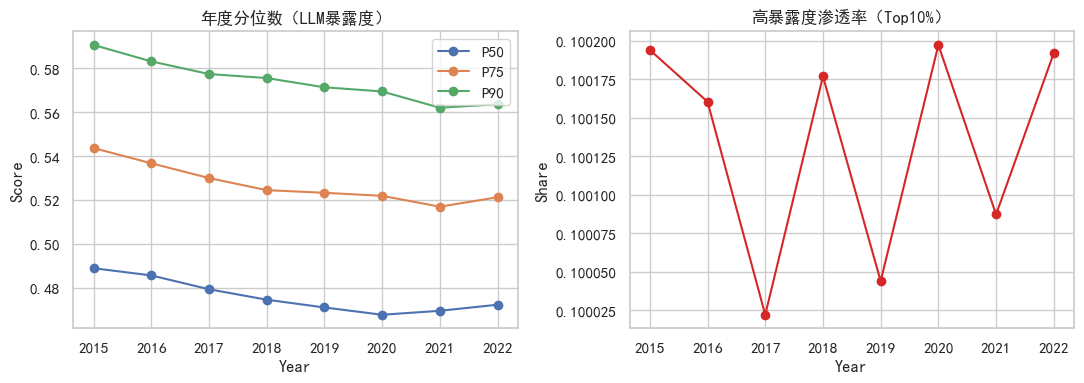

In [13]:
# 分位数与渗透率
pct = (
    year_enriched2.dropna(subset=['score', 'year'])
                 .groupby('year')['score']
                 .quantile([0.5, 0.75, 0.9])
                 .unstack()
)
pct.columns = ['P50', 'P75', 'P90']
display(pct.reset_index())

def _flag_top10(df: pd.DataFrame) -> pd.DataFrame:
    thr = df['score'].quantile(0.9)
    return df.assign(is_top10=df['score'] >= thr)

flagged = (
    year_enriched2.dropna(subset=['score', 'year'])
                .groupby('year', group_keys=False)
                .apply(_flag_top10)
)
penetration = flagged.groupby('year')['is_top10'].mean()
display(penetration.reset_index(name='top10_share'))

# 中文字体（如无对应字体，可忽略）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].plot(pct.index, pct['P50'], marker='o', label='P50')
ax[0].plot(pct.index, pct['P75'], marker='o', label='P75')
ax[0].plot(pct.index, pct['P90'], marker='o', label='P90')
ax[0].set_title('年度分位数（LLM暴露度）')
ax[0].set_xlabel('Year'); ax[0].set_ylabel('Score'); ax[0].legend()

ax[1].plot(penetration.index, penetration.values, marker='o', color='tab:red')
ax[1].set_title('高暴露度渗透率（Top10%）')
ax[1].set_xlabel('Year'); ax[1].set_ylabel('Share')
plt.tight_layout(); plt.show()

### 行业渗透率热力图（Top 行业）
按行业统计每年 Top10% 占比，展示最近年份排名靠前的行业。

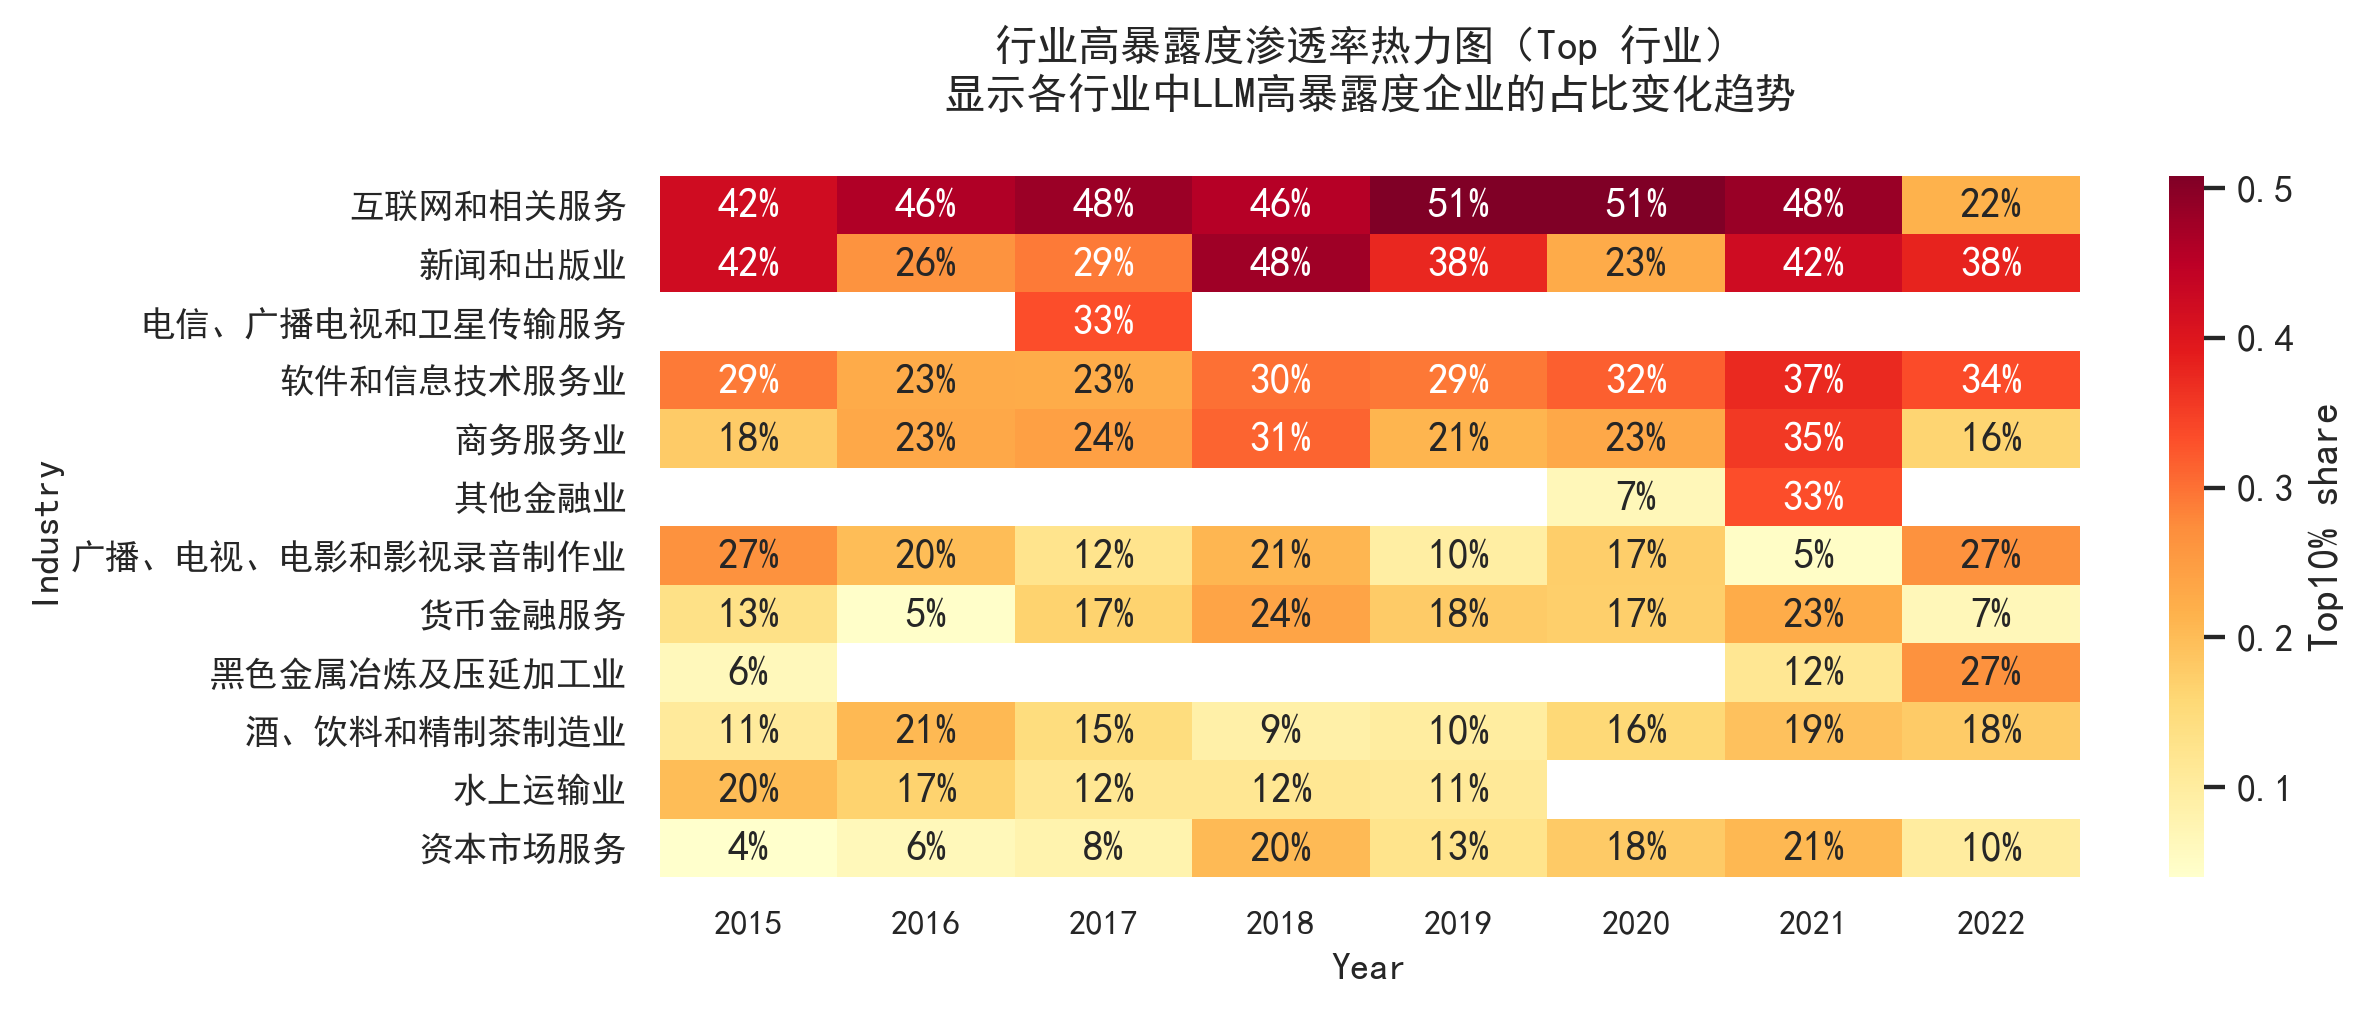

In [19]:
# 计算各行业在每年的高暴露度企业占比
# 这个热力图展示了不同行业中LLM暴露度排名前10%的企业占该行业总企业数的比例
# 颜色越深表示该行业高暴露度企业占比越高，说明该行业整体受LLM影响程度更大
ind_share = (
    flagged.groupby(['year', 'industry'])['is_top10']
           .agg(share='mean', n='size')  # share: 高暴露度企业占比, n: 行业企业总数
           .reset_index()
)
# 过滤样本量过小的行业（例如 >= 15），确保统计结果的可靠性
ind_share_f = ind_share[ind_share['n'] >= 15].copy()

# 选择平均高暴露度占比最高的前12个行业
top_inds = (
    ind_share_f.groupby('industry')['share']
              .mean()
              .sort_values(ascending=False)
              .head(12)
              .index
)

# 构建热力图数据：行业 x 年份 的高暴露度占比矩阵
heat = (
    ind_share_f[ind_share_f['industry'].isin(top_inds)]
              .pivot(index='industry', columns='year', values='share')
)
# 按平均占比从高到低排序
avg_share = heat.mean(axis=1)
heat = heat.loc[avg_share.sort_values(ascending=False).index]
# 绘制热力图
plt.figure(figsize=(10, max(4, 0.35*len(heat))), dpi=250)  # 增加dpi提高清晰度
sns.heatmap(heat, annot=True, fmt='.0%', cmap='YlOrRd', 
           cbar_kws={'label': 'Top10% share'})
plt.title('行业高暴露度渗透率热力图（Top 行业）\n显示各行业中LLM高暴露度企业的占比变化趋势', 
         fontsize=12, pad=20)  # 调整标题字体大小和间距
plt.xlabel('Year', fontsize=11)
plt.ylabel('Industry', fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().grid(False)  # 删除背景灰色网格
plt.tight_layout()
plt.show()

### 领跑者（最新年份 Top 企业）
列出最新年份 LLM 暴露度最高的企业，便于做个案研判。

In [20]:
leaders = (
    year_enriched2[year_enriched2['year'] == latest_year]
        .sort_values('score', ascending=False)
        .drop_duplicates('code')
        .head(20)
)
display(leaders[['code','short_name','industry','score']])

,code,short_name,industry,score
28375,603733,仙鹤股份,造纸及纸制品业,1.000000
12547,300299,富春股份,软件和信息技术服务业,0.980263
20573,600269,赣粤高速,道路运输业,0.916667
30174,688058,宝兰德,软件和信息技术服务业,0.916667
1879,000766,通化金马,医药制造业,0.875000
3684,002057,中钢天源,化学原料及化学制品制造业,0.833333
24643,601228,广州港,水上运输业,0.833333
20252,600202,哈空调,电气机械及器材制造业,0.833333
25364,601916,浙商银行,货币金融服务,0.833333
14468,300569,天能重工,电气机械及器材制造业,0.800000


### 月度动量与波动性（行业层面）
- 动量：最近12个月行业均值的线性斜率；
- 波动性：最新年份行业月度得分的标准差。

C:\Users\zy222\AppData\Local\Temp\ipykernel_46836\608325016.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  momentum = recent.groupby('industry').apply(slope_12m).sort_values(ascending=False).rename('slope_12m')


industry
房屋建筑业                0.046173
建筑安装业                0.035631
石油和天然气开采业            0.010552
教育                   0.009970
农业                   0.009747
木材加工及木、竹、藤、棕、草制品业    0.008422
道路运输业                0.005753
餐饮业                  0.005188
化学纤维制造业              0.004322
非金属矿物制品业             0.004045
Name: slope_12m, dtype: float64

industry
房屋建筑业             0.221431
建筑安装业             0.190363
教育                0.179309
农业                0.178049
电力、热力生产和供应业       0.176305
石油加工、炼焦及核燃料加工业    0.171085
水上运输业             0.170565
黑色金属冶炼及压延加工业      0.169060
渔业                0.163315
化学纤维制造业           0.158539
Name: score, dtype: float64

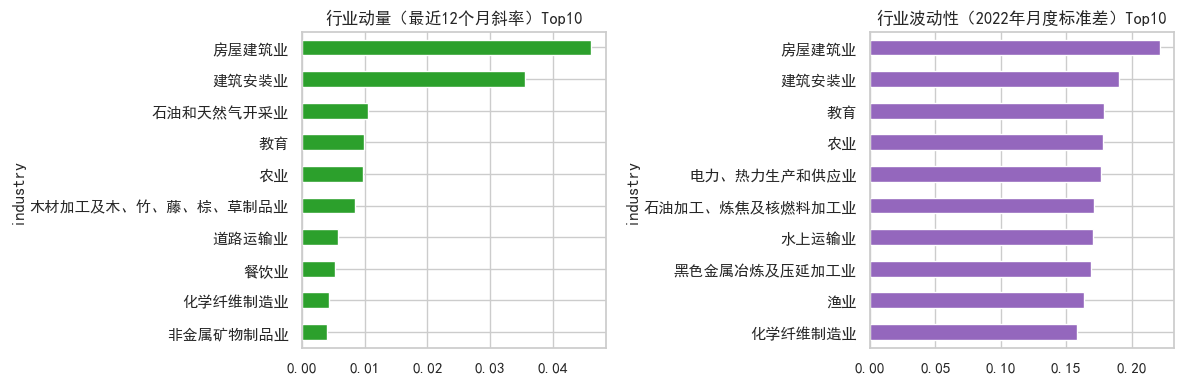

In [21]:
# 行业-月份均值
m_ind = (
    month_enriched.assign(industry=month_enriched['industry'].fillna('未知行业'))
                 .groupby(['industry','year_month'])['score']
                 .mean()
                 .reset_index()
)
last_month = m_ind['year_month'].max()
start_month = (last_month - pd.offsets.DateOffset(months=11)).to_timestamp('M') if hasattr(last_month, 'to_timestamp') else last_month - pd.offsets.DateOffset(months=11)
recent = m_ind[m_ind['year_month'] >= start_month].copy()

def slope_12m(g: pd.DataFrame) -> float:
    g = g.sort_values('year_month')
    x = np.arange(len(g))
    y = g['score'].to_numpy()
    return np.polyfit(x, y, 1)[0] if len(g) >= 3 else np.nan

momentum = recent.groupby('industry').apply(slope_12m).sort_values(ascending=False).rename('slope_12m')
display(momentum.head(10))

# 最新年份行业月度波动性
vol = (
    month_enriched[month_enriched['year'] == latest_year]
        .assign(industry=month_enriched['industry'].fillna('未知行业'))
        .groupby('industry')['score'].std()
        .sort_values(ascending=False)
)
display(vol.head(10))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
momentum.head(10).iloc[::-1].plot(kind='barh', ax=ax[0], color='tab:green')
ax[0].set_title('行业动量（最近12个月斜率）Top10')
vol.head(10).iloc[::-1].plot(kind='barh', ax=ax[1], color='tab:purple')
ax[1].set_title(f'行业波动性（{latest_year}年月度标准差）Top10')
plt.tight_layout(); plt.show()

### 稳健性：年度与月度口径一致性
对同一代码-年份，比较年度得分与当年月度均值的相关性。

In [22]:
monthly_avg = (
    month_enriched.groupby(['code','year'])['score'].mean().reset_index(name='score_month_mean')
)
annual_vs_month = (
    year_df.rename(columns={'score':'score_year'})
           .merge(monthly_avg, on=['code','year'], how='inner')
)
corr = annual_vs_month[['score_year','score_month_mean']].corr().iloc[0,1]
print('年度与月度均值的相关系数:', round(float(corr), 4))
display(annual_vs_month.head())

年度与月度均值的相关系数: 0.94


,code,year,score_year,score_month_mean
0,000001,2015,0.533768,0.538803
1,000001,2016,0.547963,0.587733
2,000001,2017,0.551261,0.551446
3,000001,2018,0.539593,0.536307
4,000001,2019,0.529949,0.538832


In [28]:
industry_stats = year_enriched.groupby('industry')['score'].agg(['mean', 'median']).sort_values('median', ascending=False)

# 按均值排序的表格
industry_mean_ranking = industry_stats.sort_values('mean', ascending=False)
industry_mean_ranking.to_csv('行业平均得分排名_按均值.csv', encoding='utf-8-sig')

# 按中位数排序的表格
industry_median_ranking = industry_stats.sort_values('median', ascending=False)
industry_median_ranking.to_csv('行业平均得分排名_按中位数.csv', encoding='utf-8-sig')